<a href="https://colab.research.google.com/github/raj-vijay/mo/blob/master/03_Metaheuristic_Optimization_SAT_%20Novelty%2B_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Metaheuristic Optimization - Novelty+

**The satisfiability problem (SAT)**
<p align = 'justify'>The satisfiability problem considers the case in which N boolean variables are used to form a Boolean expression involving negation (NOT), conjunction (AND) and disjunction (OR). The problem is to determine whether there is any assignment of values to the Boolean variables which makes the formula true. It's something like trying to flip a bunch of switches to find the setting that makes a light bulb turn on.</p>

In [ ]:
# Import libraries and modules required for the algorithm
import sys
import random
import numpy as np
import time
import matplotlib.pyplot as plt

**CNF Class**

Define CNF class to read, process and solve instances of CNF files.

In [ ]:
class CNF():
    def __init__(self, cnf_instance, solution_instance):
      # Define and initialize the class interface with data varibales required
      self.n = 0 # n is the number of variables
      self.variables = [] # List of variables in the CNF
      self.c = 0 # Number of clauses
      self.clauses = {} # Dictionary of clauses
      self.e_clauses = {} # Clauses for processing

      self.sol = {} # 

      self.cnf_instance = cnf_instance # instance of the CNF file in DIMACS format
      self.read_instance(cnf_instance) # Read CNF Instance

**CNF Files**
<p align = 'justify'>CNF is a data directory which contains examples of files stored using the DIMACS CNF file format. This format is used to define a Boolean expression, written in conjunctive normal form, that may be used as an example of the satisfiability problem. </p>

Add method to read instances of CNF Files to the CNF Class.

In [ ]:
class CNF(CNF):
  # Define methods to read and process the CNF files, note that some section of this code is based on lab exercises performed earlier during the course
  def read_instance(self, cnf_instance):
    with open(cnf_instance) as file:
      cnf = ''
      for line in file.readlines():
        if line.startswith('c'): 
          continue
        elif line.startswith('%'): 
          break
        elif line.startswith('p'):
          self.n = int(line.split()[2])
          self.c = int(line.split()[3])
        else:
          cnf += line.strip()
      self.variables = [v for v in range(1, self.n + 1) ]
      for v in self.variables:
        self.e_clauses[int(v)] = [] # Inititailze xi
        self.e_clauses[int(-v)] = [] # -xi is the negation of xi.
      for c in cnf.split(' 0')[:-1]:
        cn = tuple(c.split())
        self.clauses[cn] = False
        for v in cn:
          self.e_clauses[int(v)].append(cn)
    # Test method
    # return variables, clauses

Define method to derive an initial solution for the SAT problem in CNF.
Randomly determine the variable assignment to true or false (0 or 1) and evaluate the resulting clauses to see if the expression is true or false. This is carried out for arriving at an initial solution.

In [ ]:
class CNF(CNF):
  # Generate initial solution to the problem
  def init(self):
    self.sol['assignment'] = []
    self.sol['UNSAT'] = 0
    # Randomly determine the variable assignment to true or false (0 or 1)
    for v in self.variables:
      if round(random.uniform(0, 1)):
        self.sol['assignment'].append(v)
      else:
        self.sol['assignment'].append(v * -1)
    for c, i in self.clauses.items():
      self.clauses[c] = bool(sum([int(v) in self.sol['assignment'] for v in c]))
    self.sol['UNSAT'] = self.c - sum([ v for v in self.clauses.values() ]) # Return number of unsatisfied clauses within CNF
    # Test method
    # return sol

<p align = 'justify'>The novelty + SAT solver is built upon a traditional local search algorithm for SAT solving. It starts with a random truth assignment for the variables, and the local search algorithm uses flips for the most appropriate variable candidate until a solution is found or a given number of flips is reached (MaxFlips), after this process the algorithm restarts itself with a new (fresh) random assignment for the variables.
A critical part of the algorithm is the variable selection function (select-variable) which indicates the next variable to be flipped in the current iteration of the algorithm. </p>

In [ ]:
class CNF(CNF):
  # Method to determing unsatisfied clauses
  def unsat_clauses(self):
    return [k for k, v in self.clauses.items() if v is False]  
  # Method to perform variabele flips and determine gains for the candidate clauses
  def flip(self, var):
    # Initialize gains
    p_gain = 0
    n_gain = 0
    
    i = abs(var) - 1
    candidate = self.sol['assignment'].copy()
    candidate[i] *= -1
    candidate_clauses = self.clauses.copy()
    for c in self.e_clauses[candidate[i]]:
      candidate_clauses[c] = True
      if self.clauses[c] == False:
        p_gain += 1
    for c in self.e_clauses[-candidate[i]]:
      if not sum([int(v) in candidate for v in c]):
        candidate_clauses[c] = False
        if self.clauses[c] == True:
          n_gain += 1
    return p_gain, n_gain, candidate_clauses
  # Method to return candidate clauses after the flips based on net gain  
  def solution(self, flip_variable, update):
    self.sol['assignment'][flip_variable - 1] = self.sol['assignment'][flip_variable - 1] * -1
    self.sol['UNSAT'] -= update['net_gain']
    self.clauses = update['candidate_clauses']
  # Method to return unsatisfied clauses
  def unsat(self):
    return self.sol['UNSAT']
  # Method to check if the soultion is satisfiable
  def solution_check(self):
    for c, i in self.clauses.items():
      if not sum([int(v) in self.sol['assignment'] for v in c]):
        return False
      return True

**Local Search for SAT**

<p align = 'justify'>Algorithm describes a traditional local search algorithm for SAT solving. It starts with a random truth assignment for the variables in F, and in the local search algorithm, the algorithm flips the most appropriate variable candidate until a solution is found or a given number of flips is reached (MaxFlips), after this process the algorithm restarts itself with a new (fresh) random assignment for the variables. A critical part of the algorithm is the variable selection function (select-variable) which indicates the next variable to be flipped in the current iteration of the algorithm.</p>

**Novelty+** 

<p align = 'justify'>Novelty+ implementation works as follows:
1. Select an unsatisfied uniformly at random clause c
2. With some probability wp select a random variable from c, while in the remaining cases use Novelty for variable selection process.

Novelty: 
1. Identify the best (V1) and second best variables (V2) in c (where best is defined in terms of maximal net gain). 
2. If V1 is not the most recently flipped variable in the clause (“minimal age”), Novelty will select this variable. Otherwise, V1 will be flipped with some probability p and V2 with some probability (1- p).</p>

In [ ]:
# Define class for Local Search for the SAT Solver with Novelty+
class LS_SAT():
  def __init__(self, cnf_instance, restarts, iterations, wp=0, p=0, tl=0):
    # Define and initialize the class interface with parameters / data varibales required
    self.cnf_instance = cnf_instance # Initialize CNF instance
    self.solution_instance = '' # Initialize solution instance
    self.restarts = restarts # Restarts
    self.iterations = iterations # Iterations
    self.wp = wp # Fixed probability wp (aka walk probability or noise setting)
    self.p = p # probability p and 1-p (also noise setting)
    self.tl = tl # As required
    
    self.cnf = CNF(self.cnf_instance, self.solution_instance)
    self.search_unsat = [] # Search space for UNSAT

  def novelty(self, cnf, iteration, lst):
    clause = random.choice(cnf.unsat_clauses()) # Select an unsatisfied clause c (uniformly at random)
    search_space = {} # Define a search space to process algorithm and store candidate variables and gains
    search_space['candidate_variable'] = list(set(abs(int(l)) for l in clause))
    search_space['gain'] = []
    # Update search space with candidate variables 
    # Identify the best Vbest and second best variables V2best in c (where best is defined in terms of maximal net gain). 
    # If Vbest is not the most recently flipped variable in the clause (“minimal age”),
    # Novelty will select this variable. Otherwise, Vbest will be flipped with some probability p and V2best with some probability (1- p).
    search_space['candidate_variable'][:] = [v for v in search_space['candidate_variable'] if not(lst[v - 1] is not None and (iteration <= lst[v - 1]))]
    if len(search_space['candidate_variable']) == 0:
      return None, None
    # (Positive/Negative/Net Gain) 
    # Given a candidate variable assignment T for a CNF formula F, let B0 be the total number of clauses that  are currently unsatisfied in F. Let T0 be the state of F if variable V is flipped. Let B1 be the total number of clauses which would be unsatisfied in T0. 
    # The net gain of V is B1 − B0. The negative gain of V is the number of clauses which are currently satisfied in T, but will become unsatisfied in T0 if V is flipped.
    # The positive gain of V is the number of clauses which are currently unsatisfied in T, but will become unsatisfied in T0 if V is flipped.
    # https://www.aaai.org/Papers/AAAI/2002/AAAI02-096.pdf
    B0 = cnf.unsat()
    n_gain_list = []
    for v in search_space['candidate_variable']:
      p_gain, n_gain, candidate_clauses = cnf.flip(v)
      B1 = B0 - p_gain + n_gain
      net_gain = B0 - B1
      n_gain_list.append(n_gain)
      search_space['gain'].append(net_gain)
      search_space[v] = {}
      search_space[v]['net_gain'] = net_gain
      search_space[v]['candidate_clauses'] = candidate_clauses
    
    flip_variable = ''
    n_gain_0 = [i for i, v in enumerate(n_gain_list) if v == 0]
    if n_gain_0:
      flip_variable = search_space['candidate_variable'][int(random.choice(n_gain_0))]
    else:
      if random.uniform(0, 1) < self.p:
        flip_variable = random.choice(search_space['candidate_variable'])
      else:
        best_idx = [i for i, v in enumerate(n_gain_list) if v == min(n_gain_list)]
        flip_variable = search_space['candidate_variable'][random.choice(best_idx)]

    lst[flip_variable - 1] = iteration + self.tl
    return flip_variable, search_space

In [ ]:
class LS_SAT(LS_SAT):
  def run(self):
    for restart in range(0, self.restarts):
      self.cnf.init() # Generate an initial solution and check if it is satisfiable
      if self.cnf.sol['UNSAT'] == 0:
        return (restart, 0, self.cnf.sol['assignment'])
      lst = [ None for x in self.cnf.variables ]
        # Iterate, filp variables and update the CNF until a solution is found
        # That is, there is no unsatisfiable clauses in the CNF
      for iteration in range(1, self.iterations + 1):
        flip_variable, search_space = self.novelty(self.cnf, iteration, lst)
        if flip_variable:
          self.cnf.solution(abs(flip_variable), search_space[flip_variable])
          if self.cnf.unsat() == 0:
            if self.cnf.solution_check():
              return (restart, iteration, self.cnf.sol['assignment'])
            else:
              return (restart, iteration, 'No solution found.')
      return (self.restarts, self.iterations, None)

In [ ]:
#100000 iterations limit or 1 minute
iterations = 100000

In [ ]:
# Use 1 for no restarts, the algorithm aims to find global maximum 
restarts = 1

In [ ]:
# Baseline parameters
wp = 0.4

In [ ]:
# p (for Novelty+) = 0.3
p = 0.3

In [ ]:
tl = 10

**Run Local Search with Novelty+ for both CNF Instances**

In [ ]:
cnf_instances = []

In [ ]:
# Secured google drive file system intergation with google colab to enable cloud native implementation
path = '/content/drive/My Drive/000.Data/MOData/uf20-0'
for i in range(2):
  cnf_instances.append(path + str(i+1) + '.cnf')
print(cnf_instances)

['/content/drive/My Drive/000.Data/MOData/uf20-01.cnf', '/content/drive/My Drive/000.Data/MOData/uf20-02.cnf']


In [ ]:
# Uncomment below section for non-secure / public cloud native integration from github
# CNF files uploaded to github are downloaded to the local filesystem in colab
#!wget 'https://raw.githubusercontent.com/raj-vijay/mo/master/Files/uf20-01.cnf'
#!wget 'https://raw.githubusercontent.com/raj-vijay/mo/master/Files/uf20-02.cnf'

In [ ]:
# Uncomment and use the below code for non-secure / public cloud native integration from github
# path = '/content/uf20-0'
# cnf_instances = []
# for i in range(2):
#   cnf_instances.append(path + str(i+1) + '.cnf')
# print(cnf_instances)

In [ ]:
solution_set= []
run_set = []
duration_set = []
iteration_set = []
total_set = []
novelty = []

In [ ]:
for instance in cnf_instances:
  novelty.append(LS_SAT(instance, restarts, iterations, p=p, tl=tl))
  solution_set.append([])
  run_set.append([])
  duration_set.append([])
  iteration_set.append([])
  total_set.append([])

In [ ]:
runs = 1000
for i in range(2):  
  for run in range(runs):
    # Capture CPU Clocktime
    start_time = time.CLOCK_PROCESS_CPUTIME_ID
    
    # Individual Search Run
    restart, iteration, solution = novelty[i].run()

    # Compute CPU clocktimes for search durations / runtimes
    duration = int((time.process_time() - start_time))
    
    # For searches leading to a solution for the SAT problem, append the solution set, runs, durations, and iterations
    if solution:
        solution_set[i].append(solution)
        run_set[i].append(run)
        duration_set[i].append(duration)
        iteration_set[i].append(iteration)
        total_set[i].append(restart*iterations + iteration)

**Statistics for CNF Instance: uf20-01**

Text(0, 0.5, 'Iterations')

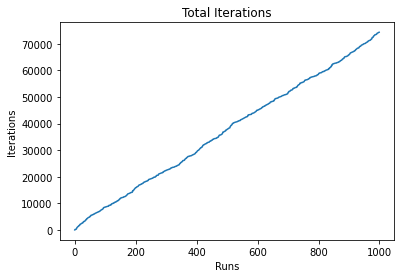

In [ ]:
plt.plot(run_set[0], np.cumsum(total_set[0]))
plt.title('Total Iterations')
plt.xlabel('Runs')
plt.ylabel('Iterations')

Text(0, 0.5, 'Iterations')

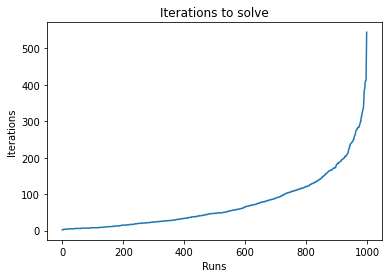

In [ ]:
plt.plot(run_set[0], sorted(iteration_set[0]))
plt.title('Iterations to solve')
plt.xlabel('Runs')
plt.ylabel('Iterations')

Text(0, 0.5, 'P(Solve)')

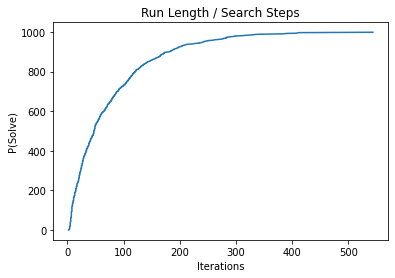

In [ ]:
plt.plot(sorted(total_set[0]), np.arange(0, len(total_set[0])))
plt.title('Run Length / Search Steps')
plt.xlabel('Iterations')
plt.ylabel('P(Solve)')

Text(0, 0.5, 'P(Solve)')

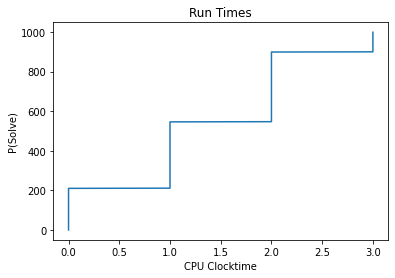

In [ ]:
plt.plot(sorted(duration_set[0]), np.arange(0, len(total_set[0])))
plt.title('Run Times')
plt.xlabel('CPU Clocktime')
plt.ylabel('P(Solve)')

**Statistics for CNF Instance: uf20-02**

Text(0, 0.5, 'Iterations')

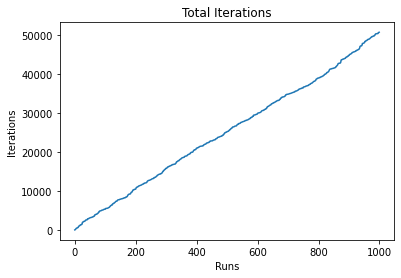

In [ ]:
plt.plot(run_set[1], np.cumsum(total_set[1]))
plt.title('Total Iterations')
plt.xlabel('Runs')
plt.ylabel('Iterations')

Text(0, 0.5, 'Iterations')

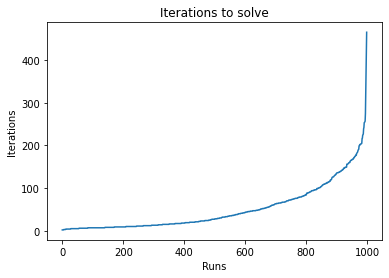

In [ ]:
plt.plot(run_set[1], sorted(iteration_set[1]))
plt.title('Iterations to solve')
plt.xlabel('Runs')
plt.ylabel('Iterations')

Text(0, 0.5, 'P(Solve)')

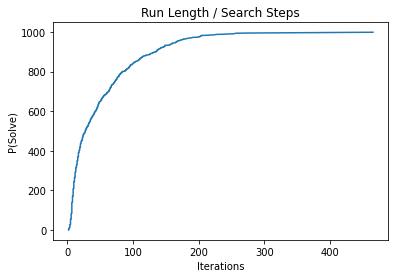

In [ ]:
plt.plot(sorted(total_set[1]), np.arange(0, len(total_set[1])))
plt.title('Run Length / Search Steps')
plt.xlabel('Iterations')
plt.ylabel('P(Solve)')

Text(0, 0.5, 'P(Solve)')

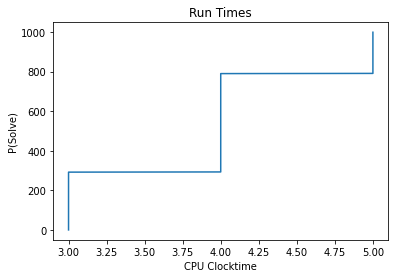

In [ ]:
plt.plot(sorted(duration_set[1]), np.arange(0, len(total_set[1])))
plt.title('Run Times')
plt.xlabel('CPU Clocktime')
plt.ylabel('P(Solve)')